# Optimization of a State-to-State Transfer in a Lambda System in the RWA

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import os
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import qutip
from qutip import Qobj
%watermark -v --iversions

Python implementation: CPython
Python version       : 3.8.1
IPython version      : 7.24.1

matplotlib: 3.4.2
krotov    : 1.2.1+dev
numpy     : 1.20.3
qutip     : 4.6.1
scipy     : 1.6.3



$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2}\mid{#2}\vphantom{#1}\right\rangle}
\newcommand{ketbra}[2]{\vert#1\rangle\!\langle#2\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}$

This example is illustrates the use of complex-valued control fields. This is
accomplished by rewriting the Hamiltonian as the sum of two independent
controls (real and imaginary parts). We consider a 3-level system in a
$\Lambda$ configuration, and seek control pulses that implement a
(phase-sensitive) state-to-state transition $\ket{1} \rightarrow \ket{3}$.

## The rotating wave Hamiltonian

The system consists of three levels $\ket{1}$, $\ket{2}$ and $\ket{3}$ with
energy levels $E_{1}, E_{2}$ and $E_{3}$ which interact with a pair of laser
pulses $\epsilon_{P}(t)$ ("pump laser") and $\epsilon_{S}(t)$ ("Stokes laser"),
respectively, see Chapter 15.4.2 in ["Introduction to Quantum Mechanics: A
Time-Dependent Perspective" by David Tannor][Tannor] for details.

[Tannor]: http://www.weizmann.ac.il/chemphys/tannor/Book/

In the lab frame, the Hamiltonian reads

$$
\Op{H}_{\text{lab}} = \begin{pmatrix}
    E_1                     & -\mu_{12} \epsilon_P(t) & 0                          \\
    -\mu_{12} \epsilon_P(t) & E_2                     & - \mu_{23} \epsilon_S(t) \\
    0                       & -\mu_{23} \epsilon_S(t) &  E_2
\end{pmatrix}\,.
$$

with the dipole values $\mu_{12}$, $\mu_{23}$ describing the coupling to the
(real-valued) control fields $\epsilon_P(t)$, $\epsilon_S(t)$. The "rotating
frame" is defined as

$$\ket{\Psi_{\text{rot}}} = \Op{U}_0^\dagger \ket{\Psi_{\text{lab}}}$$

with the transformation

$$\op{U}_{0} = \ketbra{1}{1}
e^{-i\left(E_{2} - \omega_{P} \right)t} + \ketbra{2}{2} e^{-iE_{2}t} +
\ketbra{3}{3} e^{-i\left(E_{2}-\omega_{S}\right)t}\,,$$

where $\omega_{P}$ and $\omega_{S}$ are the two central frequencies defining
the rotating frame.

The condition of having to fulfill the Schrödinger equation in the rotating
frame implies a rotating frame Hamiltonian defined as

$$\op{H}_{\text{rot}}  = \op{U}_{0}^{\dagger} \op{H}_{\text{lab}} \op{U}_{0}  - i \op{U}_{0}^{\dagger} \dot{\op{U}}_{0}\,.$$

Note that most textbooks use $\Op{U}$ instead of $\Op{U}^\dagger$, and thus the
adjoint of the above equation to define the rotating frame transformation, but
we follow the example of Tannor's book here.

The rotating frame Hamiltonian reads
$$
\Op{H}_\text{rot} = \begin{pmatrix}
    E_1 + \omega_P - E_2                      & -\mu_{12} \epsilon_P(t) e^{-i \omega_P t} & 0                          \\
    -\mu_{12} \epsilon_P(t) e^{+i \omega_P t} &  0                                        & - \mu_{23} \epsilon_S(t) e^{-i \omega_S t}\\
    0                                         & -\mu_{23} \epsilon_S(t) e^{+i \omega_S t} &  E3 + \omega_S -E_2
\end{pmatrix}\,.
$$

We can now write the fields as

$$
\begin{split}
\mu_{12} \epsilon_{P}(t)
    &= \Omega_{P}^{(1)}(t) \cos{(\omega_P t)} - \Omega_{P}^{(2)}(t) \sin{(\omega_P t)} \\
    &= \Omega_{P}^{(1)}(t) \left( e^{i \omega_P t} + e^{-i \omega_P t}\right)
        + i \Omega_{P}^{(2)}(t) \left( e^{i \omega_P t} - e^{-i \omega_P t} \right) \,,
\end{split}
$$

and similarly for $\epsilon_{S}(t)$, where we have split each field into two
arbitrary (real-valued) auxiliary fields $\Omega_{P}^{(1)}(t),
\Omega_{P}^{(2)}(t)$, and $\Omega_{S}^{(1)}(t), \Omega_{S}^{(2)}(t)$. This
rewriting is suggestive of controls being spectrally centered around $\omega_P$
and $\omega_S$, respectively, in which case any oscillations in
$\Omega_{P,S}^{(1,2)}(t)$ are on a much slower time scale than $\omega_{P, S}$.
Mathematically, however, *any* control fields can written in the above form.
Thus, we have not placed any restriction on the controls at this time.

Plugging this into $\Op{H}_\text{rot}$ and invoking the rotating wave
approximation that neglects all fast oscillating terms $\propto e^{\pm i 2
\omega_{P,S} t}$, we find

$$
\Op{H}_\text{RWA} = \begin{pmatrix}
    \Delta_P                    & -\frac{1}{2} \Omega_P(t)   & 0                          \\
    -\frac{1}{2} \Omega_P^*(t)  &  0                         &  -\frac{1}{2} \Omega_S(t)  \\
    0                           & -\frac{1}{2} \Omega_S^*(t) & \Delta_S
\end{pmatrix}\,,
$$

with the detunings $\Delta_P \equiv E_1 + \omega_P - E_2$, $\Delta_S  \equiv E3
+ \omega_S -E_2$ and the complex-valued control fields $\Omega_P(t) \equiv
\Omega_{P}^{(1)}(t) + i \Omega_{P}^{(2)}(t)$ and $\Omega_S(t) \equiv
\Omega_{S}^{(1)}(t) + i \Omega_{S}^{(2)}(t)$, illustrated in the following
diagram:

![Lambda system considered in this notebook](energylevels.png)

Most textbooks (including Tannor's) only allow control fields of the form
$\epsilon_{P,S}(t) \propto \Omega_{P,S}(t) \cos{(\omega_{P,S} t)}$ with the
pulse envelopes $\Omega_{P,S}(t) \in \mathbb{R}^+$. This will result in the
same $\Op{H}_\text{RWA}$ as above, but with the positive real-valued envelopes
instead of the complex-valued $\Omega_{P,S}(t)$. However, this restriction is
unnecessary: complex-valued control fields in the RWA are more general and
entirely physical, with the relation to the real-valued field in the lab
frame as defined above. The spectra of the optimized pulses are free to deviate
from the frequencies of the rotating frame, limited only by the numerical
resolution of the time grid and the RWA.

The `krotov` package requires that all control pulses are real-valued.
Therefore, the real and imaginary parts of $\Omega_{P}$ and $\Omega_{S}$ are
treated as independent Hamiltonians, and we write

$$
\Op{H}_\text{RWA}
    = \Op{H_0}
    + \Omega_{P}^{(1)}(t) \Op{H}_{P,\text{re}}
    + \Omega_{P}^{(2)}(t) \Op{H}_{P,\text{im}}
    + \Omega_{S}^{(1)}(t) \Op{H}_{S,\text{re}}
    + \Omega_{S}^{(2)}(t) \Op{H}_{S,\text{im}}
$$

for the purpose of the optimization, with

$$
\begin{align}
\Op{H_0} &= \Delta_P \ketbra{1}{1} + \Delta_S \ketbra{3}{3}\,, \\
\Op{H}_{P,\text{re}} &= -\frac{1}{2} \left(\ketbra{1}{2} + \ketbra{2}{1}\right)\,, \\
\Op{H}_{P,\text{im}} &= -\frac{i}{2} \left(\ketbra{1}{2} - \ketbra{2}{1}\right)\,, \\
\Op{H}_{S,\text{re}} &= -\frac{1}{2} \left(\ketbra{2}{3} + \ketbra{3}{2}\right)\,, \\
\Op{H}_{S,\text{im}} &= -\frac{i}{2} \left(\ketbra{2}{3} - \ketbra{3}{2}\right)\,.
\end{align}
$$

## Guess controls

We choose the initial guess for the four control fields based on the intuition
of the "stimulated Raman adiabatic passage" (STIRAP) scheme. STIRAP allows to
transfer the population in $\ket{1}$ $\ket{3}$ without having to pass through
$\ket{2}$; it requires the Stokes-pulse to precede but overlap the pump-pulse.

Here, we leave it up to Krotov's method to find appropriate pulses for a
STIRAP-like transfer (without requiring that the $\ket{2}$ level remains
unpopulated).  We start from a low intensity real-valued $\Omega_S(t)$ pulse
with a Blackman shape, followed by an overlapping real-valued $\Omega_P(t)$ of
the same shape. The entire scheme is in the time interval [0, 5].

In [2]:
def Omega_P1(t, args):
    """Guess for the real part of the pump pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=2.0, t_stop=5.0)


def Omega_P2(t, args):
    """Guess for the imaginary part of the pump pulse"""
    return 0.0


def Omega_S1(t, args):
    """Guess for the real part of the Stokes pulse"""
    Ω0 = 5.0
    return Ω0 * krotov.shapes.blackman(t, t_start=0.0, t_stop=3.0)


def Omega_S2(t, args):
    """Guess for the imaginary part of the Stokes pulse"""
    return 0.0

We can now instantiate the Hamiltonian including these guess controls:

In [3]:
def hamiltonian(E1=0.0, E2=10.0, E3=5.0, omega_P=9.5, omega_S=4.5):
    """Lambda-system Hamiltonian in the RWA"""

    # detunings
    ΔP = E1 + omega_P - E2
    ΔS = E3 + omega_S - E2

    H0 = Qobj([[ΔP, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, ΔS]])

    HP_re = -0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    HP_im = -0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])

    HS_re = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    HS_im = -0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])

    return [
        H0,
        [HP_re, Omega_P1],
        [HP_im, Omega_P2],
        [HS_re, Omega_S1],
        [HS_im, Omega_S2],
    ]


In [4]:
H = hamiltonian()

## Target state in the rotating frame

The basis states of the $\Lambda$-system are defined as

In [5]:
ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))

We would like to implement a phase-sensitive transition $\ket{1} \rightarrow
\ket{3}$ *in the lab frame*. Since we are defining the dynamics in the RWA,
this means we have to adjust the target state to be in the rotating frame as
well (the initial state at $t=0$ is not affected by the RWA).

As defined earlier, the states in the rotating frame are obtained from the
states in the lab frame by the transformation $\ket{\Psi_{\text{rot}}} =
\Op{U}_0^\dagger \ket{\Psi_{\text{lab}}}$. In our case, this means that we get
$\ket{3}$ with and additional phase factor:

In [6]:
def rwa_target_state(ket3, E2=10.0, omega_S=4.5, T=5):
    return np.exp(1j * (E2 - omega_S) * T) * ket3

In [7]:
psi_target = rwa_target_state(ket3)

We can now instantiate the control objective:

In [8]:
objective = krotov.Objective(initial_state=ket1, target=psi_target, H=H)
objective

Objective[|Ψ₀(3)⟩ to |Ψ₁(3)⟩ via [H₀[3,3], [H₁[3,3], u₁(t)], [H₂[3,3], u₂(t)], [H₃[3,3], u₃(t)], [H₄[3,3], u₄(t)]]]

## Simulate dynamics under the guess field

We use a time grid with 500 steps between $t=0$ and $T=5$:

In [9]:
tlist = np.linspace(0, 5, 500)

Before propagating, we visually verify the guess pulses we defined earlier:

In [10]:
def plot_pulse(pulse, tlist, label):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('%s pulse amplitude' % label)
    plt.show(fig)

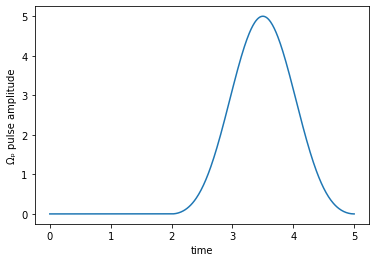

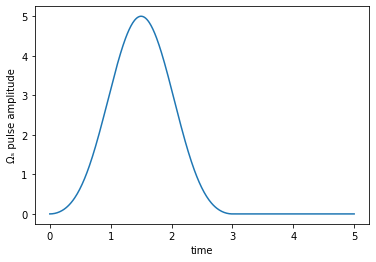

In [11]:
plot_pulse(H[1][1], tlist, 'Ωₚ')
plot_pulse(H[3][1], tlist, 'Ωₛ')

The imaginary parts are zero:

In [12]:
assert np.all([H[2][1](t, None) == 0 for t in tlist])
assert np.all([H[4][1](t, None) == 0 for t in tlist])

We introduce projectors $\op{P}_{i} =
\ketbra{i}{i}$ for each of the three energy levels, allowing use to plot the population dynamics:

In [13]:
proj1 = qutip.ket2dm(ket1)
proj2 = qutip.ket2dm(ket2)
proj3 = qutip.ket2dm(ket3)

In [14]:
guess_dynamics = objective.mesolve(tlist, e_ops=[proj1,proj2,proj3])

In [15]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)

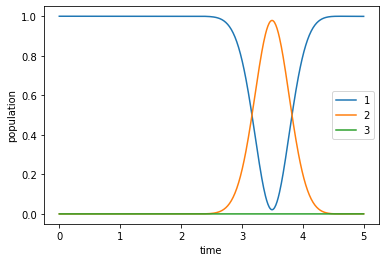

In [16]:
plot_population(guess_dynamics)

We find that our guess pulses are too disjoint to implement the STIRAP scheme.
Thus, the Stokes pulse has no effect, whilst the pump pulse merely transfers
population out of $\ket{1}$ into $\ket{2}$ and back again.

## Optimize

In order to invoke `optimize_pulses`, we must define the required parameters
for each control, a pulse shape (used to ensure that the controls remain 0 at
$t=0$ and $t=T$), and the parameter $\lambda_a$ that determines the overall
magnitude of the pulse updates in each iteration.

In [17]:
def S(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(
        t, t_start=0.0, t_stop=5.0, t_rise=0.3, func='sinsq'
    )

In [18]:
pulse_options = {
    H[1][1]: dict(lambda_a=0.5, update_shape=S),
    H[2][1]: dict(lambda_a=0.5, update_shape=S),
    H[3][1]: dict(lambda_a=0.5, update_shape=S),
    H[4][1]: dict(lambda_a=0.5, update_shape=S)
}

We now run the optimization, using the phase-sensitive functional $J_{T,
\text{re}} = 1 - \Re\Braket{\Psi(t)}{\Psi_{\tgt}}$, printing the integrated
pulse update for each control in each iteration. The optimization stops when
$J_T$ falls below $10^{-3}$, changes by less than $10^{-5}$, or after at most
15 iterations. We also check for monotonic convergence.

In [19]:
opt_result = krotov.optimize_pulses(
    [objective],
    pulse_options,
    tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.print_table(
        J_T=krotov.functionals.J_T_re,
        show_g_a_int_per_pulse=True,
        unicode=False,
    ),
    check_convergence=krotov.convergence.Or(
        krotov.convergence.value_below(1e-3, name='J_T'),
        krotov.convergence.delta_below(1e-5),
        krotov.convergence.check_monotonic_error,
    ),
    iter_stop=15,
)

iter.      J_T   g_a_int_1   g_a_int_2   g_a_int_3   g_a_int_4    g_a_int          J  Delta J_T    Delta J  secs
0     1.01e+00    0.00e+00    0.00e+00    0.00e+00    0.00e+00   0.00e+00   1.01e+00        n/a        n/a     0
1     6.72e-01    8.60e-02    2.87e-04    8.17e-02    3.72e-04   1.68e-01   8.40e-01  -3.37e-01  -1.68e-01     1
2     4.02e-01    7.20e-02    4.21e-04    6.22e-02    4.20e-04   1.35e-01   5.37e-01  -2.70e-01  -1.35e-01     1
3     2.22e-01    4.91e-02    4.64e-04    3.99e-02    3.88e-04   8.98e-02   3.12e-01  -1.80e-01  -8.98e-02     1
4     1.17e-01    2.89e-02    3.87e-04    2.29e-02    3.01e-04   5.25e-02   1.69e-01  -1.05e-01  -5.25e-02     1
5     6.00e-02    1.56e-02    2.69e-04    1.23e-02    2.10e-04   2.84e-02   8.84e-02  -5.69e-02  -2.84e-02     1
6     3.05e-02    8.08e-03    1.71e-04    6.37e-03    1.39e-04   1.48e-02   4.52e-02  -2.95e-02  -1.48e-02     1
7     1.54e-02    4.08e-03    1.06e-04    3.24e-03    9.10e-05   7.51e-03   2.30e-02  -1.50e-02 

In [20]:
opt_result

Krotov Optimization Result
--------------------------
- Started at 2021-11-07 05:51:35
- Number of objectives: 1
- Number of iterations: 12
- Reason for termination: Reached convergence: J_T < 0.001
- Ended at 2021-11-07 05:51:59 (0:00:24)

We dump the result of the optimization to disk for later use in the [Ensemble
Optimization for Robust Pulses](08_example_ensemble.ipynb).


In [21]:
if not os.path.isfile('lambda_rwa_opt_result.dump'):
    opt_result.dump('lambda_rwa_opt_result.dump')

The optimized complex pulses look as follows:

pump pulse amplitude and phase:


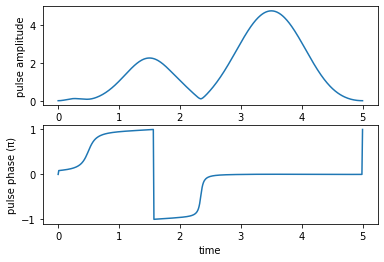

Stokes pulse amplitude and phase:


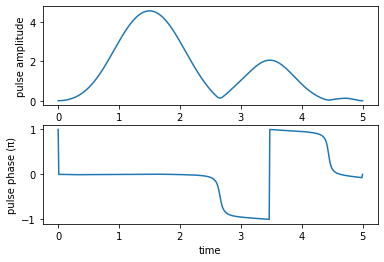

In [22]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')
    plt.show()

print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)

We can convert the complex controls in the rotating frame back into the
real-valued pulses in the lab frame:

Physical electric pump pulse in the lab frame:


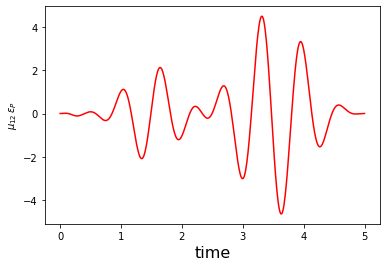

Physical electric Stokes pulse in the lab frame:


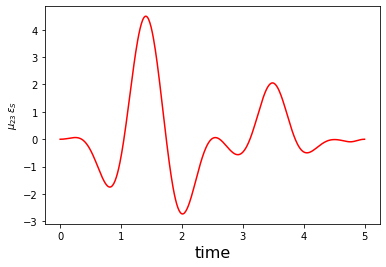

In [23]:
def plot_physical_field(pulse_re, pulse_im, tlist, case=None):

    if case == 'pump':
        w = 9.5
    elif case == 'stokes':
        w = 4.5
    else:
        print('Error: selected case is not a valid option')
        return

    ax = plt.subplot(111)
    ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
    ax.set_xlabel('time', fontsize = 16)
    if case == 'pump':
        ax.set_ylabel(r'$\mu_{12}\,\epsilon_{P}$')
    elif case == 'stokes':
        ax.set_ylabel(r'$ \mu_{23}\,\epsilon_{S}$')
    plt.show()

print('Physical electric pump pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist, case = 'pump')


print('Physical electric Stokes pulse in the lab frame:')
plot_physical_field(
    opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist, case = 'stokes')

Lastly, we check the population dynamics to verify that we indeed implement the
desired state-to-state transfer:

In [24]:
opt_dynamics = opt_result.optimized_objectives[0].mesolve(
    tlist, e_ops=[proj1, proj2, proj3])

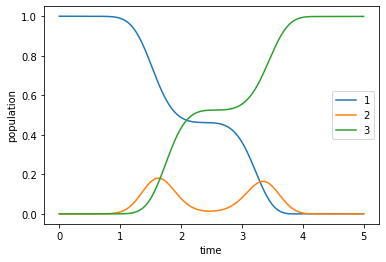

In [25]:
plot_population(opt_dynamics)